# Heart Beat Classifier
---


## Load the bitstream into the Programmable Logic

In [1]:
%reload_ext autoreload
%autoreload 2
# Import the X-HEEP Python class
from pynq import x_heep
# Allow the import of all modules in this directory
import sys
import os

SDK_PATH = "/home/xilinx/x-heep-femu-sdk/"
RISCV_PATH = 'sw/riscv/'
APP_PATH = SDK_PATH + RISCV_PATH + 'apps/HBC/'
NB_PATH         = SDK_PATH + 'arm/apps/HBC/'     # Path to this notebook
# ADC_BIN_NAME = 'adc_in'

sys.path.append(SDK_PATH + "sw/arm/apps/HBC")

# from timeseries import *
# from report import *

# Load the X-HEEP bitstream
xh = x_heep()

print("Bitstream loaded")

Bitstream loaded


## Compile the code and run the application

You can change the variable `VERBOSE`       to 0 to supress the live printing of the UART.

In [2]:
import time
import math
# Wether to see the X-HEEP UART output live.
VERBOSE         = 0
# Enable the printfs inside X-HEEP application. This is not the same as VERBOSE, as it actually reflects in C-code and therefore in performance.
ENABLE_PRINTF   = 1

# Application data
SUBJECT = 2
ECG_VECTOR_SIZE = 15000 # Number of samples per lead
RMS_NLEADS         = 3 # ADC Channels
SAMPLE_FREQ        = 250 # (Hz)
data_file_name = f"/home/xilinx/x-heep-femu-sdk/sw/arm/apps/HBC/data/ecg_3l_{SUBJECT}.bin"

# Define some standards to parse the X-HEEP output
OUTPUT_START_SEQ    = "# "
OUTPUT_DIVIDER      = "|"
OUTPUT_END_SEQ      = "#---"

# Write the definitions header file to share information with the C code
defs = APP_PATH + 'definitions.h'
xh.open_definitions (defs, "DEFINITIONS")
xh.add_definition   (defs, "ENABLE_PRINTF",     ENABLE_PRINTF)
xh.add_definition   (defs, "OUTPUT_START_SEQ",  OUTPUT_START_SEQ)
xh.add_definition   (defs, "OUTPUT_DIVIDER",    OUTPUT_DIVIDER)
xh.add_definition   (defs, "OUTPUT_END_SEQ",    OUTPUT_END_SEQ)
xh.add_definition   (defs, "ECG_VECTOR_SIZE",    ECG_VECTOR_SIZE)
xh.add_definition   (defs, "SUBJECT",    SUBJECT + 1)
xh.close_definitions (defs)

# Compile the application
xh.compile_app("HBC")
print("Compilation complete!")


✅ Compile SUCCESS
Compilation complete!


In [3]:
# Start a background thread that reads from the Virtual ADC
ddr_thread, ddr_sf = xh.virtual_adc_thread_start(data_file_name)

# Start a background thread that reads from the UART
t, sf = xh.thread_start(VERBOSE)

# Set the performance counters
perf_cnt = xh.init_perf_cnt()       # Init the performance counters
xh.reset_perf_cnt(perf_cnt)         # Reset the performance counters
xh.start_perf_cnt_manual(perf_cnt)  # Start the performance counters

time.sleep(3)

out, _ = xh.run_app()               # Run the application (disregarding the error output)

# Finish
xh.stop_perf_cnt(perf_cnt)          # Stop the performance counters
xh.thread_stop(t, sf)               # Stop the background thread that reads from the UART
xh.thread_stop(ddr_thread, ddr_sf)  # Stop the ddr circular buffer controller

xh.uart_data

SatHB
mrodsi#0


Exception in thread Thread-6 (thread_process_uart_read):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 946, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xilinx/x-heep-femu-sdk/sw/arm/sdk/x_heep_api.py", line 85, in thread_process_uart_read
    line = serialPort.readline().decode('utf-8')
  File "/usr/local/share/pynq-venv/lib/python3.10/site-packages/serial/serialposix.py", line 595, in read
    raise SerialException(
serial.serialutil.SerialException: device reports readiness to read but returned no data (device disconnected or multiple access on port?)


nw0 BOMLBAT
Win #1
Window 1: ABNORMAL_BEAT!
Win #2
Window 2: ABNORMAL_BEAT!
Win #3
Window 3: ABNORMAL_BEAT!
Finished HBC
✅ Return SUCCESS
 


['SatHB\n',
 'tr CNube f winow: 4\n',
 'mrodsi#0\n',
 'nw0 BOMLBAT\n',
 'Win #1\n',
 'Window 1: ABNORMAL_BEAT!\n',
 'Win #2\n',
 'Window 2: ABNORMAL_BEAT!\n',
 'Win #3\n',
 'Window 3: ABNORMAL_BEAT!\n',
 'Finished HBC\n']

## Correctness against golden reference

In [4]:
import numpy as np

f = open(data_file_name, mode="rb")
file_byte = f.read()
f.close()
data_all = np.frombuffer(file_byte, dtype=np.int16, count=-1, offset=0)

data = np.empty(shape=(3,ECG_VECTOR_SIZE))
data[0] = data_all[range(0, len(data_all), 3)]
data[1] = data_all[range(1, len(data_all), 3)]
data[2] = data_all[range(2, len(data_all), 3)]

data_plot = data[0][range(0, 1000)]

1000


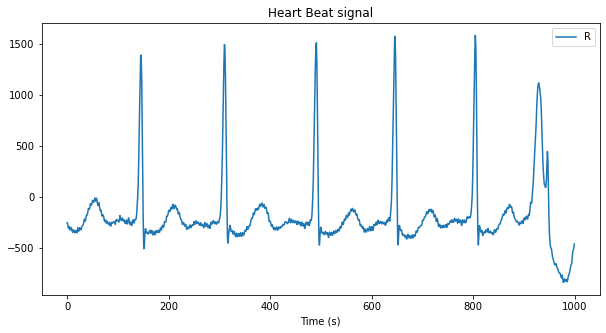

In [5]:
import matplotlib.pyplot as plt

time_v = range(len(data_plot)) # in ms

# Plot the desired signals
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
print(len(data_plot))

ax.plot(time_v, data_plot)

ax.legend("Reference")
ax.set_xlabel("Time (s)")
ax.set_title(f"Heart Beat signal")

plt.show()

## Performance and Energy

This will generate a report in `sw/riscv/build/energy_estim.csv`. 

Run the `estim.ipynb` notebook to visualize the results. 

In [6]:
# Define some budgets that we should not cross
POWER_BUDGET_W      = 100e-6
LATENCY_BUDGET_S    = 1

xh.read_perf_cnt(perf_cnt);         # Read the performance counters
xh.estimate_performance(False);     # Estimate the performance
xh.estimate_energy("HVT", False);   # Estimate the energy

rep_summary, rep_latency, rep_energy  = report() # Get the report

# Check that some contraints are satisfied
print("---------------------")
if rep_summary['Power_W']   < POWER_BUDGET_W:   print("✅ Power SUCCESS")
else: print("❌ Power FAIL")
if rep_summary['Latency_s'] < LATENCY_BUDGET_S: print("✅ Latency SUCCESS")
else: print("❌ Latency FAIL")

# Remove modules that will not be used in the design
pruned_energy = remove_module(rep_energy, "always-on peripheral subsystem" )
pruned_energy = remove_module(pruned_energy, "debug ao" )
pruned_energy = remove_module(pruned_energy, "spi" )
pruned_energy = remove_module(pruned_energy, "i2c" )

# Plot a breakdown of the energy consumption
plot_energy( pruned_energy, level=1 )

# In case you want to print the dictionaries containing the breakdown
if 0:
    import pprint
    pprint.pprint(pruned_energy)

NameError: name 'report' is not defined